In [1]:
############# A simple Memory Model for Mruty(2016) #############
### pyactup implementation 
### Author: CherYang
### Date: 2020-02-14
##############################################################

## init
import pyactup
import pyibl
import pprint
import numpy
import random
import math
import pprint as p
import matplotlib.pyplot as plt

random.seed(0)
### An abstract reward task stimulus: house stimulus amount of money associated with it
class HouseStimulus:
    def __init__(self, stimulus, amount):
        self.stimulus=stimulus
        self.amount=amount
        ### decide category
        self.category=self.decide_category(self.amount) 
    
    def decide_category(self, amount):
        if amount >=2.5: 
            return 'high'
        else:
            return 'low'
    def __str__(self):
        return (self.stimulus, self.amount, self.category)

class Task:
    def __init__(self, num_houses):
        self.n=num_houses
        self.reward_task_stimuli=self.create_house_stimuli(num_houses)
        self.decision_task_stimuli=self.create_decision_task_stimuli(num_houses)
    
    #    """this function create a set of stimuli (n) as a list"""
    def create_house_stimuli(self, n, show=False):
        stimuli=[]
        for i in range(n):
            stimuli.append(HouseStimulus("house"+str(i+1), float(i)/2))
        ## test
        if show:
            print('--- reward task stimuli ---')
            for i in stimuli:
                print (i.__str__())
        return stimuli   
    
    # this function generate 
    def create_decision_task_stimuli(self, n, show=False):
        stimuli=[]+self.create_house_stimuli(n)
        for i in range(n):
            stimuli.append(HouseStimulus("new_house"+str(i+1), float(i)/2))
        if show:
            print('--- decision-task stimuli ---')
            for i in stimuli:
                print (i.__str__())
        return stimuli 
    
#"""this function print items in memory (dict)"""
def show_memory(m):
    print('--- memory ---')
    for k,v in m.items():
        print('key: ', k, 'v: ', v)

#"""this function decompose the chunk into its content"""
def get_chunk_content(c):
    if c is not None:
        #['house0', 2.61, 'unknown']
        house_name=list(c.values())[0]
        house_amount=list(c.values())[1]
        house_category=list(c.values())[2]
        return (house_name, house_amount, house_category)
    else: 
        return None

# plot the activation trace given the dict index  
def plot_each(index):
    plt.plot(base_act[index], 'black')
    plt.plot(act[index], 'o')
    
    plt.ylim([numpy.min(act[index]), numpy.max(act[index])])
    plt.title(f"retrieve high category 1000 times \nσ={m.noise}, d={m.decay}")
    plt.ylabel("activation")
    plt.xlabel("time retrieval")
    plt.show()

###################### Reward Task ######################
### Method1: learn (house,amount,category) as pairs house0, 
#"""Create a pyactup memory item and learn house stimulus, encode house stimulus, exact amount, and category"""
def mlearn_houses(show=False):
    m=pyactup.Memory()
    m.reset()
    for i in range (10):
        curr_house=HouseStimulus("house"+str(i+1), float(i)/2)
        m.learn(stimulus=curr_house.stimulus, 
                amount=curr_house.amount,
                category=curr_house.category)
        m.learn(stimulus='house0',
               amount=random.randrange(500)/100,
               category='unknown')
        m.advance()
    if show:
        for k,v in m.items():
            print ('key: ', k, 'v: ', v)
    return m
################# Memory task ######################
### Method1: assumes can only remeber high-category houses mapping. 
### memory task: see a house stimulus (house(i)), always trying to retrieve a high-category item. ;(
### decision task: if successfully retrieved, choose this house(i). Otherwise, choose random house

### Method2: assume always successfully recall the category
## memory task: see a house stimulus, decide if it is high/low category (no retrieval here)
        # based on category, retrieve a chunk from memory 
## decision task: if retrieved memory is matching seen house (in stimulus and amount), choose this house, 
        # otherwise, choose random house
    
### Method3: assume always successfully recall exact details
## memory task: see a house stimulus, directly retrieve a memory
## decision task: if retrieved memory is matching seen house (in stimulus and amount), choose this house, 
        # otherwise, choose random house

## 1) retrieve based on category
    # if retrieved chunk matches in stimulus -> can recall house-category
    # payoff=1
    # else payoff=0
## see a stimulus, get number

## 2) retrieve based on amount (only very high) or very low (later in social)
    # if retrieved chunk matches -> can recall exact house-amount
    # payoff=exact amount

{'house0': 1500,
 'house1': 0,
 'house10': 100,
 'house2': 0,
 'house3': 0,
 'house4': 0,
 'house5': 0,
 'house6': 100,
 'house7': 100,
 'house8': 100,
 'house9': 100}


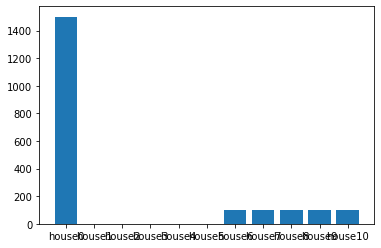

In [2]:
random.seed(0)
t=Task(10)

#init memory
m=pyactup.Memory()
m.activation_history=[]
# m.threshold=-3

# activation trace
act={i:[] for i in range(10)}
base_act={i:[] for i in range(10)}
base_act_time={i:[] for i in range(10)}

#Reward Task: learn house-reward association
for h in t.reward_task_stimuli:
    m.learn(stimulus=h.stimulus, amount=h.amount, category=h.category)
    m.learn(stimulus="house0", amount=random.randrange(500)/100, category='uncertain')
    m.advance()

#Memory Task + Decision-making task
count={"house"+str(k):0 for k in range(11)}
NUM_SUBJ=100
for i in range(NUM_SUBJ):
    for trial in t.decision_task_stimuli:
        c=m.retrieve(stimulus=trial.stimulus, 
                                 amount=trial.amount, 
                                 category=trial.category)
        curr_chunk=get_chunk_content(c)
        if c is not None:
            #print('curr: ', get_chunk_content(c)[2])
            ## successfully retrieve item, and in high category
            ## decide to choose this one
            if curr_chunk[2]=="high":
                count[curr_chunk[0]]+=1
                ## re-encode info
                m.learn(stimulus=curr_chunk[0], 
                amount=curr_chunk[1], 
                category=curr_chunk[2])
                m.advance()
            else:
                ## successfully retrieve item, but in low category
                ## decide to choose a random house
                count["house0"]+=1
            # record 
            act[c._references[0]].append(c._activation())
            base_act[c._references[0]].append(c._base_activation)
            base_act_time[c._references[0]].append(c._base_activation_time)
        else:
            #print('fail to retrieve') 
            ## fail to retrieve item, decide to choose random one
            count["house0"]+=1
        m.advance()

pprint.pprint(count)
plt.bar(list(count.keys()), list(count.values()))
plt.show()